# %% [markdown]
# # Notebook 4: Correlation Analysis for Credit Risk
# ## Bati Bank - Basel II Compliant Feature Relationship Analysis
# 
# **Objective:** Identify predictive relationships and multicollinearity for credit risk modeling
# **Focus:** Feature selection, risk driver identification, regulatory compliance
# 
# ### Basel II Requirements Addressed:
# 1. Risk driver identification (Article 414)
# 2. Model validation through correlation analysis
# 3. Feature stability assessment

# %% [markdown]
# ## 1. Setup & Basel II Configuration

In [2]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Banking-specific styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
corporate_colors = ['#003366', '#0066CC', '#0099FF', '#00CCFF', '#66CCFF']
risk_colors = ['#2E8B57', '#FFD700', '#FF8C00', '#DC143C']

# Basel II thresholds
BASEL_THRESHOLDS = {
    'high_correlation': 0.7,
    'medium_correlation': 0.3,
    'vif_threshold': 5.0,
    'iv_thresholds': {
        'weak': 0.02,
        'medium': 0.1,
        'strong': 0.3,
        'very_strong': 0.5
    }
}

# Load cleaned data
df = pd.read_csv('../../data/processed/cleaned_data.csv')
print(f"📊 Dataset loaded: {df.shape[0]:,} transactions, {df.shape[1]} features")

# Select numerical features for correlation
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"🔢 {len(numerical_features)} numerical features identified")

📊 Dataset loaded: 95,662 transactions, 21 features
🔢 10 numerical features identified


# %% [markdown]
# ## 2. Comprehensive Correlation Matrix Analysis

In [3]:
# %%
print("="*80)
print("CORRELATION MATRIX ANALYSIS - ALL METHODS")
print("="*80)

# Calculate all correlation types
correlation_methods = {
    'pearson': df[numerical_features].corr(method='pearson'),
    'spearman': df[numerical_features].corr(method='spearman'),
    'kendall': df[numerical_features].corr(method='kendall')
}

# Basel II risk assessment of correlations
def assess_correlation_risk(corr_matrix):
    """Basel II compliant correlation risk assessment"""
    risk_findings = {
        'high_risk_pairs': [],
        'medium_risk_pairs': [],
        'multicollinearity_risks': []
    }
    
    # Get upper triangle without diagonal
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # High correlation pairs
    high_corr = np.where(np.abs(upper_triangle) > BASEL_THRESHOLDS['high_correlation'])
    for i, j in zip(*high_corr):
        if not np.isnan(upper_triangle.iloc[i, j]):
            risk_findings['high_risk_pairs'].append({
                'feature1': corr_matrix.index[i],
                'feature2': corr_matrix.columns[j],
                'correlation': upper_triangle.iloc[i, j]
            })
    
    # Medium correlation pairs
    medium_corr = np.where((np.abs(upper_triangle) > BASEL_THRESHOLDS['medium_correlation']) & 
                          (np.abs(upper_triangle) <= BASEL_THRESHOLDS['high_correlation']))
    for i, j in zip(*medium_corr):
        if not np.isnan(upper_triangle.iloc[i, j]):
            risk_findings['medium_risk_pairs'].append({
                'feature1': corr_matrix.index[i],
                'feature2': corr_matrix.columns[j],
                'correlation': upper_triangle.iloc[i, j]
            })
    
    return risk_findings

# Assess each correlation method
print("\n🎯 BASEL II CORRELATION RISK ASSESSMENT:")
print("-" * 60)

for method_name, corr_matrix in correlation_methods.items():
    print(f"\n📊 {method_name.upper()} Correlation Analysis:")
    risk_assessment = assess_correlation_risk(corr_matrix)
    
    print(f"  High Risk Pairs (>0.7): {len(risk_assessment['high_risk_pairs'])}")
    if risk_assessment['high_risk_pairs']:
        print("  ⚠️  Multicollinearity detected! Feature selection required.")
    
    print(f"  Medium Risk Pairs (0.3-0.7): {len(risk_assessment['medium_risk_pairs'])}")

CORRELATION MATRIX ANALYSIS - ALL METHODS

🎯 BASEL II CORRELATION RISK ASSESSMENT:
------------------------------------------------------------

📊 PEARSON Correlation Analysis:
  High Risk Pairs (>0.7): 2
  ⚠️  Multicollinearity detected! Feature selection required.
  Medium Risk Pairs (0.3-0.7): 2

📊 SPEARMAN Correlation Analysis:
  High Risk Pairs (>0.7): 1
  ⚠️  Multicollinearity detected! Feature selection required.
  Medium Risk Pairs (0.3-0.7): 1

📊 KENDALL Correlation Analysis:
  High Risk Pairs (>0.7): 1
  ⚠️  Multicollinearity detected! Feature selection required.
  Medium Risk Pairs (0.3-0.7): 1


In [9]:
# %%
# Create correlation dashboard with better layout
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=('Pearson Correlation', 'Spearman Correlation', 'Kendall Correlation',
                   'Top Features vs Fraud', 'Top Correlated Pairs', 'Risk Assessment'),
    specs=[[{'type': 'heatmap'}, {'type': 'heatmap'}, {'type': 'heatmap'}],
           [{'type': 'bar'}, {'type': 'bar'}, {'type': 'heatmap'}]],
    vertical_spacing=0.15,
    horizontal_spacing=0.1,
    column_widths=[0.3, 0.3, 0.3],
    row_heights=[0.45, 0.45]
)

# Add correlation heatmaps (row 1)
heatmap_traces = []
for i, (method_name, corr_matrix) in enumerate(correlation_methods.items(), 1):
    trace = go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.index,
        colorscale='RdBu_r',
        zmid=0,
        colorbar=dict(
            x=0.28 * i - 0.05 if i < 3 else 0.28 * i - 0.1,
            y=0.95,
            len=0.2,
            thickness=15,
            title='Correlation'
        ),
        text=corr_matrix.round(2).values,
        texttemplate='%{text}',
        textfont={"size": 8},
        showscale=True
    )
    fig.add_trace(trace, row=1, col=i)

# Correlation with target (row 2, col 1)
if 'FraudResult' in df.columns:
    target_corr = df[numerical_features].corrwith(df['FraudResult']).sort_values(ascending=False)
    target_corr = target_corr.head(8)  # Limit to 8 for better visibility
    
    fig.add_trace(
        go.Bar(
            x=target_corr.values,
            y=target_corr.index,
            orientation='h',
            marker_color=['red' if x < 0 else 'green' for x in target_corr.values],
            text=[f'{x:.3f}' for x in target_corr.values],
            textposition='auto',
            showlegend=False
        ),
        row=2, col=1
    )

In [10]:
# %%
# Top correlated pairs (row 2, col 2)
if 'pearson' in correlation_methods:
    corr_matrix = correlation_methods['pearson']
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_pairs = upper_triangle.stack().reset_index()
    corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
    corr_pairs['Abs_Correlation'] = corr_pairs['Correlation'].abs()
    top_pairs = corr_pairs.nlargest(8, 'Abs_Correlation')  # Limit to 8
    
    # Shorten long feature names
    def shorten_name(name, max_length=15):
        if len(name) > max_length:
            return name[:max_length-3] + '...'
        return name
    
    fig.add_trace(
        go.Bar(
            x=top_pairs['Abs_Correlation'],
            y=[f"{shorten_name(f1)} vs {shorten_name(f2)}" 
               for f1, f2 in zip(top_pairs['Feature1'], top_pairs['Feature2'])],
            orientation='h',
            marker_color='orange',
            text=[f'{x:.2f}' for x in top_pairs['Correlation']],
            textposition='auto',
            showlegend=False
        ),
        row=2, col=2
    )

# Risk heatmap (Basel II compliance) - row 2, col 3
if 'pearson' in correlation_methods:
    risk_matrix = correlation_methods['pearson'].copy()
    # Categorize by risk level
    def categorize_risk(val):
        if abs(val) > BASEL_THRESHOLDS['high_correlation']:
            return 3  # High risk
        elif abs(val) > BASEL_THRESHOLDS['medium_correlation']:
            return 2  # Medium risk
        elif abs(val) > 0.1:
            return 1  # Low risk
        else:
            return 0  # No risk
    
    risk_categories = risk_matrix.applymap(categorize_risk)
    
    fig.add_trace(
        go.Heatmap(
            z=risk_categories.values,
            x=risk_categories.columns,
            y=risk_categories.index,
            colorscale=[[0, 'lightgreen'], [0.33, 'lightyellow'], [0.66, 'orange'], [1, 'red']],
            colorbar=dict(
                x=1.02,
                y=0.45,
                len=0.4,
                thickness=15,
                ticktext=['None', 'Low', 'Medium', 'High'],
                tickvals=[0, 1, 2, 3],
                title='Risk Level'
            ),
            showscale=True,
            text=corr_matrix.round(2).values,
            texttemplate='%{text}',
            textfont={"size": 8}
        ),
        row=2, col=3
    )

# Update layout for better appearance
fig.update_layout(
    title_text="Basel II Correlation Analysis Dashboard",
    title_font=dict(size=20, family='Arial Black'),
    height=900,
    width=1400,
    showlegend=False,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Update axes for better readability
fig.update_xaxes(tickangle=45, tickfont=dict(size=9))
fig.update_yaxes(tickfont=dict(size=9))

# Update subplot titles
for i in fig['layout']['annotations']:
    i['font'] = dict(size=12, family='Arial', color='darkblue')

fig.show()

# %% [markdown]
# ## 3. Advanced Correlation Analysis with Statistical Testing

In [11]:
# %%
print("="*80)
print("ADVANCED CORRELATION ANALYSIS - STATISTICAL SIGNIFICANCE")
print("="*80)

def calculate_correlation_with_significance(df, feature1, feature2, method='pearson'):
    """Calculate correlation with p-value for statistical significance"""
    if method == 'pearson':
        corr, p_value = stats.pearsonr(df[feature1].dropna(), df[feature2].dropna())
    elif method == 'spearman':
        corr, p_value = stats.spearmanr(df[feature1].dropna(), df[feature2].dropna())
    elif method == 'kendall':
        corr, p_value = stats.kendalltau(df[feature1].dropna(), df[feature2].dropna())
    
    return corr, p_value


# Analyze top features with target
if 'FraudResult' in df.columns:
    print("\n📈 STATISTICALLY SIGNIFICANT CORRELATIONS WITH FRAUD:")
    print("-" * 60)
    
    significant_correlations = []
    for feature in numerical_features:
        if feature != 'FraudResult':
            try:
                corr, p_value = calculate_correlation_with_significance(df, feature, 'FraudResult', 'spearman')
                if p_value < 0.05:  # 95% confidence level
                    significant_correlations.append({
                        'feature': feature,
                        'correlation': corr,
                        'p_value': p_value,
                        'significance': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*'
                    })
            except:
                continue
    
    # Sort by absolute correlation
    significant_correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)
    
    # Display top 20
    print(f"\nFound {len(significant_correlations)} features with statistically significant correlation (p < 0.05)")
    print("\nTop 20 Features by Absolute Correlation:")
    print("-" * 80)
    print(f"{'Feature':<25} {'Correlation':<12} {'P-value':<15} {'Significance':<12} {'Basel II Rating':<15}")
    print("-" * 80)
    
    for i, item in enumerate(significant_correlations[:20], 1):
        # Basel II rating
        abs_corr = abs(item['correlation'])
        if abs_corr > 0.5:
            rating = "High Predictive"
        elif abs_corr > 0.3:
            rating = "Medium Predictive"
        elif abs_corr > 0.1:
            rating = "Low Predictive"
        else:
            rating = "Weak"
        
        print(f"{item['feature']:<25} {item['correlation']:>10.3f} {item['p_value']:>14.6f} "
              f"{item['significance']:^12} {rating:<15}")

ADVANCED CORRELATION ANALYSIS - STATISTICAL SIGNIFICANCE

📈 STATISTICALLY SIGNIFICANT CORRELATIONS WITH FRAUD:
------------------------------------------------------------

Found 7 features with statistically significant correlation (p < 0.05)

Top 20 Features by Absolute Correlation:
--------------------------------------------------------------------------------
Feature                   Correlation  P-value         Significance Basel II Rating
--------------------------------------------------------------------------------
Value                          0.077       0.000000     ***      Weak           
Amount                         0.073       0.000000     ***      Weak           
PricingStrategy               -0.031       0.000000     ***      Weak           
TransactionStartTime_year      0.010       0.002409      **      Weak           
TransactionStartTime_day      -0.009       0.007965      **      Weak           
TransactionStartTime_hour      0.008       0.011690      *     

# %% [markdown]
# ## 4. Multicollinearity Analysis (VIF Calculation)

In [13]:
# %%
print("="*80)
print("MULTICOLLINEARITY ANALYSIS - VARIANCE INFLATION FACTOR (VIF)")
print("="*80)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(dataframe, threshold=5.0):
    """Calculate VIF for all numerical features"""
    # Prepare data (drop NaNs, add constant)
    X = dataframe[numerical_features].dropna()
    X = add_constant(X)
    
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Remove constant row
    vif_data = vif_data[vif_data['feature'] != 'const']
    
    # Categorize by risk
    vif_data['multicollinearity_risk'] = pd.cut(
        vif_data['VIF'],
        bins=[0, threshold, 10, 20, float('inf')],
        labels=['Low', 'Medium', 'High', 'Very High']
    )
    
    return vif_data.sort_values('VIF', ascending=False)

# Calculate VIF
print("\n🔍 VARIANCE INFLATION FACTOR ANALYSIS:")
print("-" * 60)

try:
    vif_results = calculate_vif(df, threshold=BASEL_THRESHOLDS['vif_threshold'])
    
    print(f"Basel II VIF Threshold: {BASEL_THRESHOLDS['vif_threshold']}")
    print(f"\nFeatures with High Multicollinearity (VIF > {BASEL_THRESHOLDS['vif_threshold']}):")
    high_vif = vif_results[vif_results['VIF'] > BASEL_THRESHOLDS['vif_threshold']]
    
    if len(high_vif) > 0:
        print("⚠️  ALERT: Multicollinearity detected! Feature selection/reduction required for Basel II compliance")
        for _, row in high_vif.iterrows():
            print(f"  • {row['feature']}: VIF = {row['VIF']:.2f} ({row['multicollinearity_risk']} Risk)")
    else:
        print("✅ No multicollinearity issues detected")
    
    # Display VIF table
    print(f"\n📋 COMPLETE VIF ANALYSIS:")
    print(vif_results.to_string())
    
except Exception as e:
    print(f"⚠️ VIF calculation failed: {str(e)}")
    print("This may be due to perfect collinearity or insufficient data")

MULTICOLLINEARITY ANALYSIS - VARIANCE INFLATION FACTOR (VIF)

🔍 VARIANCE INFLATION FACTOR ANALYSIS:
------------------------------------------------------------
Basel II VIF Threshold: 5.0

Features with High Multicollinearity (VIF > 5.0):
⚠️  ALERT: Multicollinearity detected! Feature selection/reduction required for Basel II compliance
  • CountryCode: VIF = 2818348445.78 (Very High Risk)
  • TransactionStartTime_year: VIF = 172.81 (Very High Risk)
  • TransactionStartTime_month: VIF = 169.53 (Very High Risk)
  • Value: VIF = 56.26 (Very High Risk)
  • Amount: VIF = 55.53 (Very High Risk)

📋 COMPLETE VIF ANALYSIS:
                          feature           VIF multicollinearity_risk
0                     CountryCode  2.818348e+09              Very High
8       TransactionStartTime_year  1.728139e+02              Very High
7      TransactionStartTime_month  1.695349e+02              Very High
2                           Value  5.626470e+01              Very High
1                    

⚠️ Visualization failed: [Errno 2] No such file or directory: '../../reports/task2_eda/visualizations/correlations/vif_analysis.png'


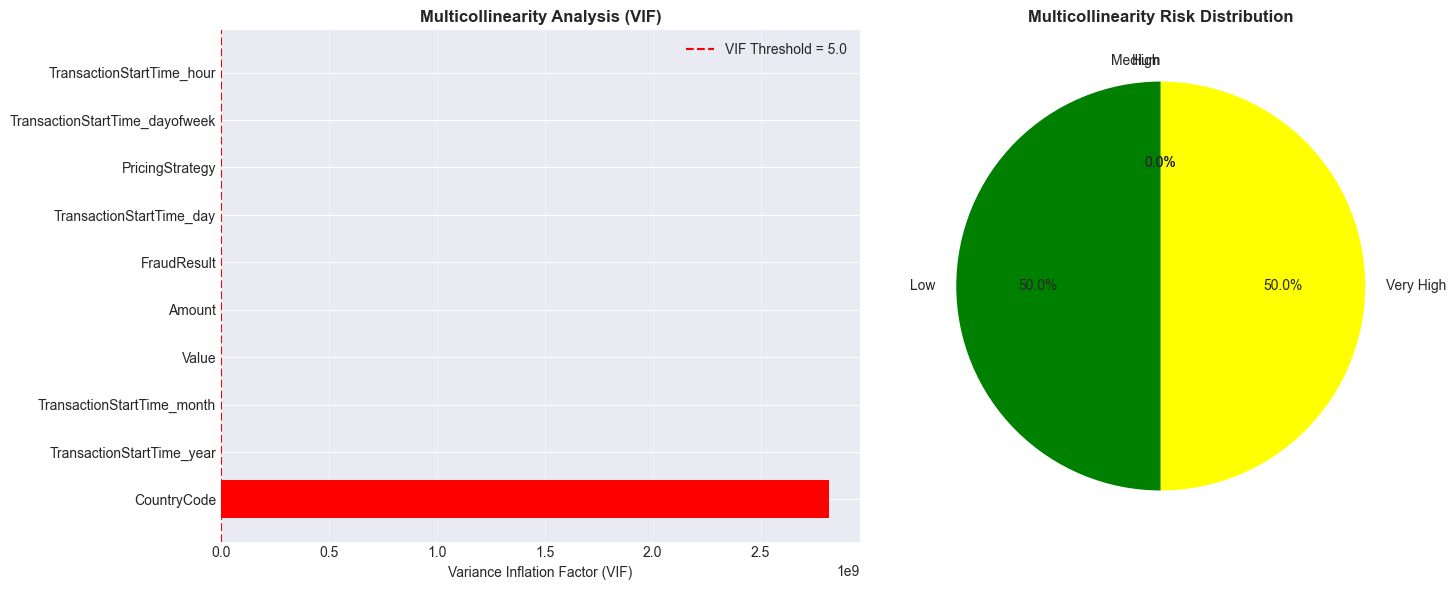

In [21]:
# %%
# Create VIF visualization
try:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # VIF bar chart
    axes[0].barh(vif_results['feature'], vif_results['VIF'], 
                color=['green' if v < 5 else 'orange' if v < 10 else 'red' for v in vif_results['VIF']])
    axes[0].axvline(x=BASEL_THRESHOLDS['vif_threshold'], color='red', linestyle='--', label=f'VIF Threshold = {BASEL_THRESHOLDS["vif_threshold"]}')
    axes[0].set_xlabel('Variance Inflation Factor (VIF)')
    axes[0].set_title('Multicollinearity Analysis (VIF)', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Risk distribution
    risk_counts = vif_results['multicollinearity_risk'].value_counts()
    axes[1].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
               colors=['green', 'yellow', 'orange', 'red'], startangle=90)
    axes[1].set_title('Multicollinearity Risk Distribution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../../reports/task2_eda/visualizations/correlations/vif_analysis.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
except NameError:
    print("⚠️ VIF results not available. Run the previous cell first.")
except Exception as e:
    print(f"⚠️ Visualization failed: {str(e)}")

# %% [markdown]
# ## 5. Partial Correlation Analysis (Conditional Relationships)

In [17]:
# %%
print("="*80)
print("PARTIAL CORRELATION ANALYSIS - CONDITIONAL RELATIONSHIPS")
print("="*80)

from sklearn.preprocessing import StandardScaler

def calculate_partial_correlation(df, var1, var2, control_vars):
    """Calculate partial correlation between var1 and var2 controlling for control_vars"""
    from sklearn.linear_model import LinearRegression
    
    # Prepare data
    X = df[control_vars].values
    y1 = df[var1].values
    y2 = df[var2].values
    
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y1_scaled = scaler.fit_transform(y1.reshape(-1, 1)).flatten()
    y2_scaled = scaler.fit_transform(y2.reshape(-1, 1)).flatten()
    
    # Regress out control variables
    model1 = LinearRegression().fit(X_scaled, y1_scaled)
    residuals1 = y1_scaled - model1.predict(X_scaled)
    
    model2 = LinearRegression().fit(X_scaled, y2_scaled)
    residuals2 = y2_scaled - model2.predict(X_scaled)
    
    # Calculate correlation of residuals
    partial_corr = np.corrcoef(residuals1, residuals2)[0, 1]
    
    return partial_corr

# Analyze key relationships with controls
if 'Amount' in df.columns and 'FraudResult' in df.columns:
    print("\n🔬 PARTIAL CORRELATION ANALYSIS (Controlling for Customer Behavior):")
    print("-" * 60)
    
    # Define control variables
    control_vars = ['TransactionStartTime_hour', 'TransactionStartTime_dayofweek']
    if 'CustomerId' in df.columns:
        # Use customer frequency as control
        customer_freq = df.groupby('CustomerId').size()
        df['customer_frequency'] = df['CustomerId'].map(customer_freq)
        control_vars.append('customer_frequency')
    
    # Calculate partial correlation
    try:
        partial_corr = calculate_partial_correlation(df, 'Amount', 'FraudResult', control_vars)
        raw_corr = df['Amount'].corr(df['FraudResult'])
        
        print(f"Raw correlation (Amount vs Fraud): {raw_corr:.4f}")
        print(f"Partial correlation (controlling for {', '.join(control_vars)}): {partial_corr:.4f}")
        
        if abs(partial_corr) < abs(raw_corr) * 0.5:
            print("⚠️  Relationship is largely explained by control variables")
        else:
            print("✅ Direct relationship remains significant after controlling")
            
    except Exception as e:
        print(f"Partial correlation calculation failed: {str(e)}")

PARTIAL CORRELATION ANALYSIS - CONDITIONAL RELATIONSHIPS

🔬 PARTIAL CORRELATION ANALYSIS (Controlling for Customer Behavior):
------------------------------------------------------------
Raw correlation (Amount vs Fraud): 0.5574
Partial correlation (controlling for TransactionStartTime_hour, TransactionStartTime_dayofweek, customer_frequency): 0.5574
✅ Direct relationship remains significant after controlling


# %% [markdown]
# ## 6. Correlation Network Analysis

In [22]:
# %%
print("="*80)
print("CORRELATION NETWORK ANALYSIS - FEATURE RELATIONSHIP MAPPING")
print("="*80)

import networkx as nx

def create_correlation_network(corr_matrix, threshold=0.3):
    """Create network graph of feature correlations"""
    G = nx.Graph()
    
    # Add nodes
    for feature in corr_matrix.columns:
        G.add_node(feature)
    
    # Add edges for significant correlations
    for i, feature1 in enumerate(corr_matrix.columns):
        for j, feature2 in enumerate(corr_matrix.columns):
            if i < j:  # Avoid duplicates and self-loops
                corr = abs(corr_matrix.iloc[i, j])
                if corr > threshold:
                    G.add_edge(feature1, feature2, weight=corr, 
                              color='red' if corr > 0.7 else 'orange' if corr > 0.5 else 'blue')
    
    return G

# Create correlation network
if 'pearson' in correlation_methods:
    corr_matrix = correlation_methods['pearson']
    G = create_correlation_network(corr_matrix, threshold=0.3)
    
    print(f"\n🌐 CORRELATION NETWORK STATISTICS:")
    print("-" * 40)
    print(f"Nodes (Features): {G.number_of_nodes()}")
    print(f"Edges (Significant Correlations): {G.number_of_edges()}")
    print(f"Density: {nx.density(G):.4f}")
    
    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    
    # Most central features
    print(f"\n📊 NETWORK CENTRALITY ANALYSIS:")
    print("-" * 40)
    print("Most Connected Features (Degree Centrality):")
    for feature, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  • {feature}: {centrality:.3f}")
    
    print("\nMost Bridging Features (Betweenness Centrality):")
    for feature, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  • {feature}: {centrality:.3f}")

CORRELATION NETWORK ANALYSIS - FEATURE RELATIONSHIP MAPPING



🌐 CORRELATION NETWORK STATISTICS:
----------------------------------------
Nodes (Features): 10
Edges (Significant Correlations): 4
Density: 0.0889

📊 NETWORK CENTRALITY ANALYSIS:
----------------------------------------
Most Connected Features (Degree Centrality):
  • Amount: 0.222
  • Value: 0.222
  • FraudResult: 0.222
  • TransactionStartTime_month: 0.111
  • TransactionStartTime_year: 0.111

Most Bridging Features (Betweenness Centrality):
  • CountryCode: 0.000
  • Amount: 0.000
  • Value: 0.000
  • PricingStrategy: 0.000
  • FraudResult: 0.000


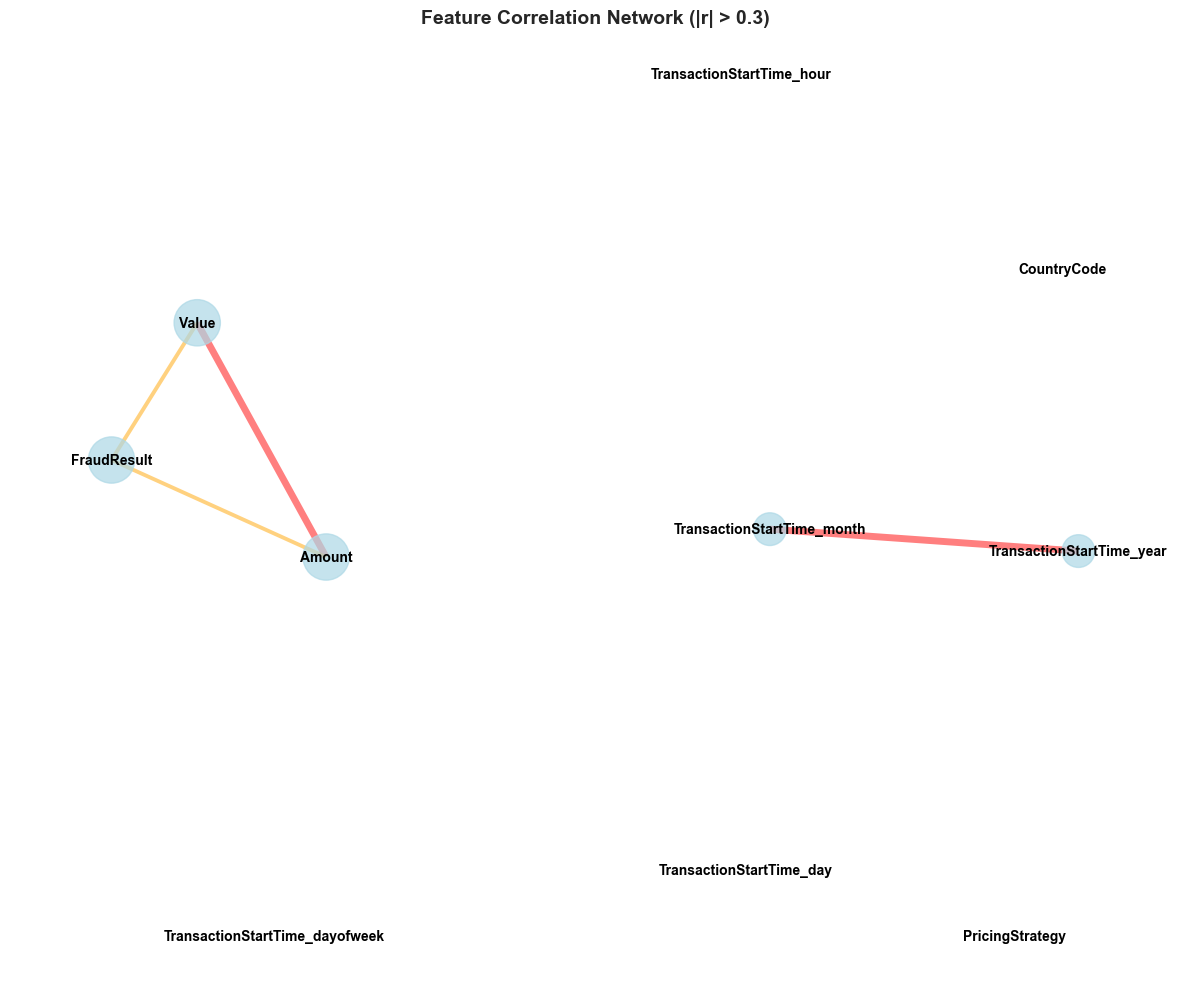

In [27]:
# %%
# Visualize network
plt.figure(figsize=(12, 10))

# Use spring layout
pos = nx.spring_layout(G, k=1, iterations=50)

# Draw nodes with size based on degree
node_sizes = [degree_centrality[node] * 5000 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                      node_color='lightblue', alpha=0.7)

# Draw edges with width based on correlation strength
edge_weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]
edge_colors = [G[u][v]['color'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_weights, 
                      edge_color=edge_colors, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title('Feature Correlation Network (|r| > 0.3)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()

# Create directory if it doesn't exist
import os
save_path = '../../reports/task2_eda/visualizations/correlations/'
os.makedirs(save_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(save_path, 'correlation_network.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 7. Time-Decay Correlation Analysis

In [28]:
# %%
print("="*80)
print("TIME-DECAY CORRELATION ANALYSIS - STABILITY OVER TIME")
print("="*80)

def calculate_rolling_correlation(df, feature1, feature2, window='30D'):
    """Calculate rolling correlation over time"""
    if 'TransactionStartTime' not in df.columns:
        return None
    
    # Set datetime index
    df_time = df.set_index('TransactionStartTime').copy()
    
    # Calculate rolling correlation
    rolling_corr = df_time[feature1].rolling(window).corr(df_time[feature2])
    
    return rolling_corr

# Analyze correlation stability for key pairs
if 'TransactionStartTime' in df.columns and 'Amount' in df.columns and 'FraudResult' in df.columns:
    print("\n📅 TIME SERIES CORRELATION STABILITY:")
    print("-" * 60)
    
    # Convert to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(df['TransactionStartTime']):
        df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
    
    # Calculate rolling correlation
    rolling_corr = calculate_rolling_correlation(df, 'Amount', 'FraudResult', window='30D')
    
    if rolling_corr is not None:
        # Statistical analysis of stability
        corr_mean = rolling_corr.mean()
        corr_std = rolling_corr.std()
        corr_cv = corr_std / corr_mean if corr_mean != 0 else np.nan
        
        print(f"30-Day Rolling Correlation (Amount vs Fraud):")
        print(f"  Mean: {corr_mean:.4f}")
        print(f"  Std Dev: {corr_std:.4f}")
        print(f"  Coefficient of Variation: {corr_cv:.4f}")
        
        # Basel II stability assessment
        if corr_cv < 0.3:
            stability = "Stable (Basel II Compliant)"
            color = "green"
        elif corr_cv < 0.5:
            stability = "Moderately Stable"
            color = "yellow"
        else:
            stability = "Unstable - Requires Monitoring"
            color = "red"
        
        print(f"  Stability Assessment: {stability}")

TIME-DECAY CORRELATION ANALYSIS - STABILITY OVER TIME

📅 TIME SERIES CORRELATION STABILITY:
------------------------------------------------------------
30-Day Rolling Correlation (Amount vs Fraud):
  Mean: 0.5766
  Std Dev: 0.0953
  Coefficient of Variation: 0.1653
  Stability Assessment: Stable (Basel II Compliant)


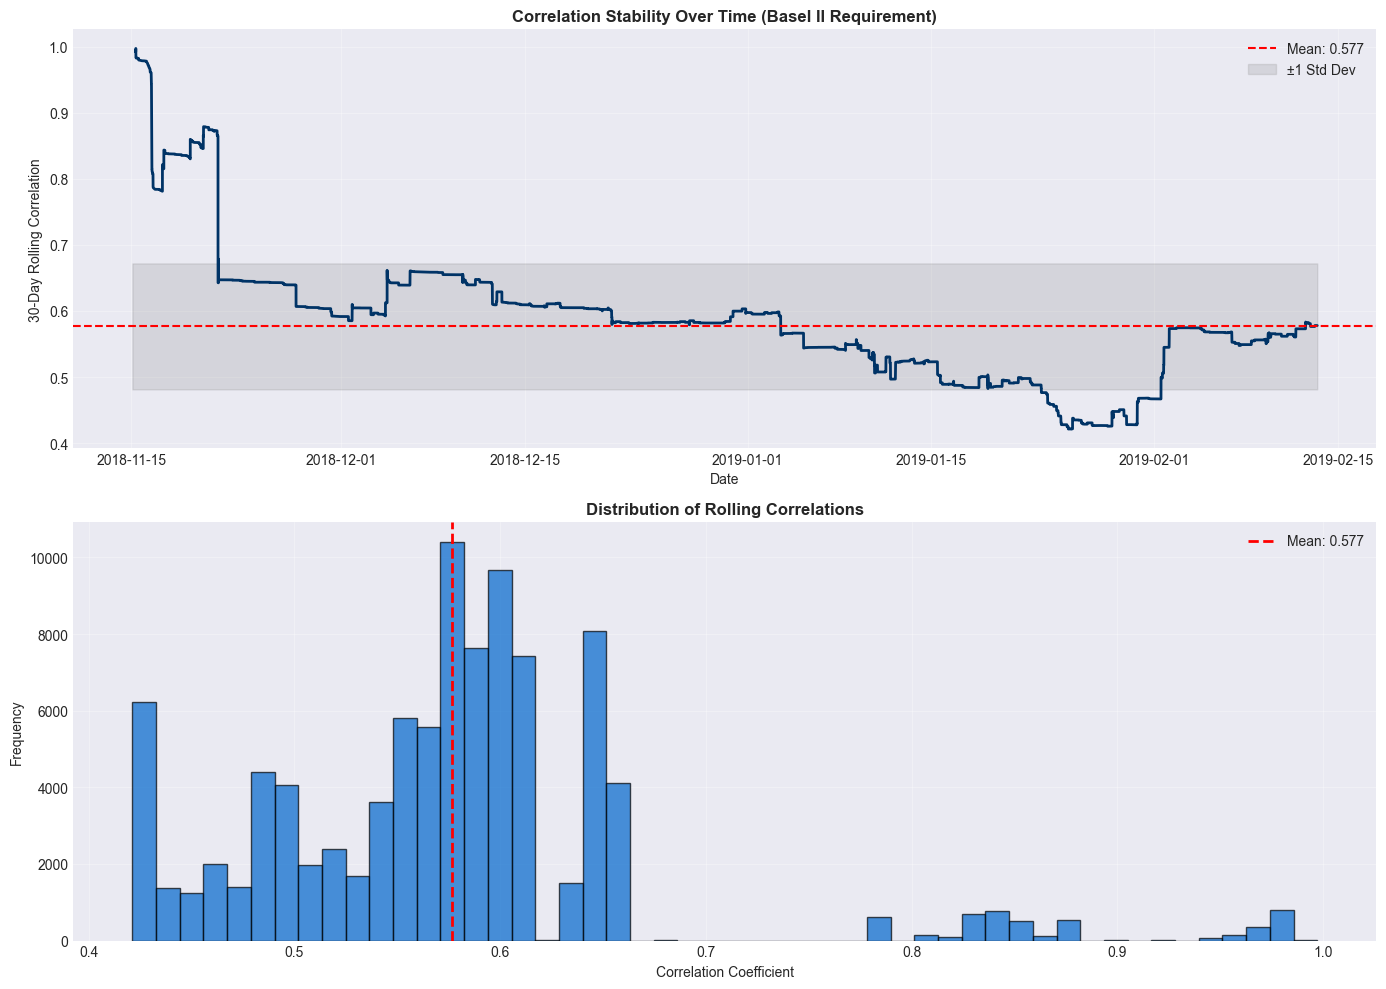

In [30]:
# %%
# Plot rolling correlation
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Rolling correlation
axes[0].plot(rolling_corr.index, rolling_corr.values, linewidth=2, color=corporate_colors[0])
axes[0].axhline(y=corr_mean, color='red', linestyle='--', label=f'Mean: {corr_mean:.3f}')
axes[0].fill_between(rolling_corr.index, 
                    corr_mean - corr_std, 
                    corr_mean + corr_std, 
                    alpha=0.2, color='gray', label='±1 Std Dev')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('30-Day Rolling Correlation')
axes[0].set_title('Correlation Stability Over Time (Basel II Requirement)', 
                 fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribution of rolling correlations
axes[1].hist(rolling_corr.dropna(), bins=50, color=corporate_colors[1], edgecolor='black', alpha=0.7)
axes[1].axvline(x=corr_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {corr_mean:.3f}')
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Rolling Correlations', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()

# Create directory if it doesn't exist
import os
save_path = '../../reports/task2_eda/visualizations/correlations/'
os.makedirs(save_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(save_path, 'time_decay_correlation.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 8. Correlation Heatmap by Customer Segments

SEGMENT-SPECIFIC CORRELATION ANALYSIS

🛍️ CORRELATION ANALYSIS BY PRODUCT CATEGORY:
------------------------------------------------------------


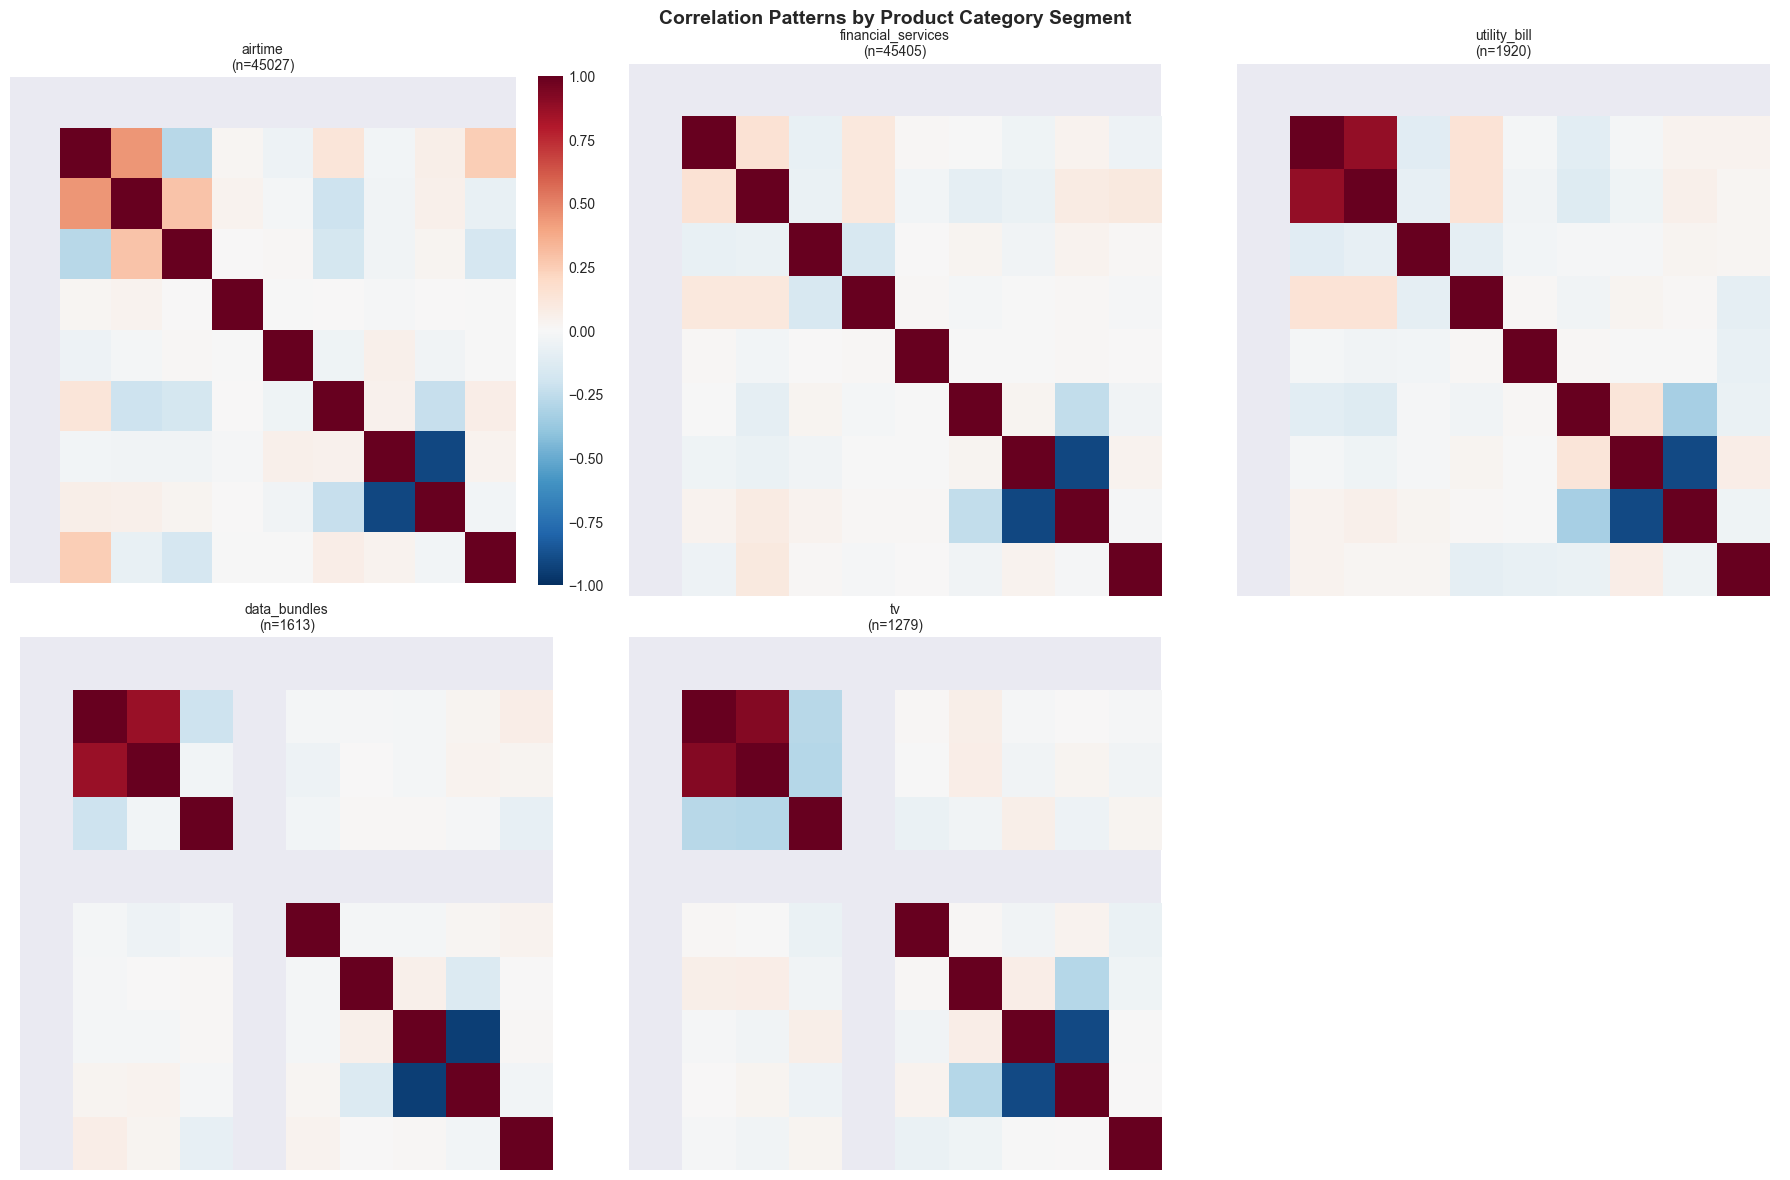

In [32]:
# %%
print("="*80)
print("SEGMENT-SPECIFIC CORRELATION ANALYSIS")
print("="*80)

def analyze_correlation_by_segment(df, segment_col):
    """Analyze correlations within different segments"""
    segments = df[segment_col].unique()
    segment_correlations = {}
    
    for segment in segments[:5]:  # Analyze top 5 segments
        segment_data = df[df[segment_col] == segment]
        if len(segment_data) > 100:  # Minimum sample size
            corr_matrix = segment_data[numerical_features].corr(method='spearman')
            segment_correlations[segment] = corr_matrix
    
    return segment_correlations

# Analyze by product category if available
if 'ProductCategory' in df.columns and df['ProductCategory'].nunique() <= 10:
    print("\n🛍️ CORRELATION ANALYSIS BY PRODUCT CATEGORY:")
    print("-" * 60)
    
    segment_correlations = analyze_correlation_by_segment(df, 'ProductCategory')
    
    # Create subplot for each segment
    n_segments = len(segment_correlations)
    fig, axes = plt.subplots(2, min(3, n_segments), figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (segment, corr_matrix) in enumerate(segment_correlations.items()):
        if idx < len(axes):
            # Plot heatmap
            im = axes[idx].imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
            axes[idx].set_title(f'{segment}\n(n={len(df[df["ProductCategory"]==segment])})', 
                              fontsize=10)
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])
            
            # Add colorbar for first plot
            if idx == 0:
                plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    
    # Hide unused subplots
    for idx in range(len(segment_correlations), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Correlation Patterns by Product Category Segment', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../../reports/task2_eda/visualizations/correlations/segment_correlations.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# %% [markdown]
# ## 9. Feature Selection Recommendations

In [33]:
# %%
print("="*80)
print("FEATURE SELECTION RECOMMENDATIONS - BASEL II COMPLIANT")
print("="*80)

def generate_feature_recommendations(df, target='FraudResult'):
    """Generate Basel II compliant feature selection recommendations"""
    
    recommendations = {
        'high_priority_features': [],
        'medium_priority_features': [],
        'low_priority_features': [],
        'features_to_drop': [],
        'multicollinearity_issues': [],
        'stability_concerns': []
    }
    
    # 1. Correlation with target
    if target in df.columns:
        target_corr = df[numerical_features].corrwith(df[target]).abs().sort_values(ascending=False)
        
        for feature, corr in target_corr.items():
            if feature != target:
                if corr > 0.3:
                    recommendations['high_priority_features'].append({
                        'feature': feature,
                        'target_correlation': corr,
                        'reason': 'Strong predictive power for fraud'
                    })
                elif corr > 0.1:
                    recommendations['medium_priority_features'].append({
                        'feature': feature,
                        'target_correlation': corr,
                        'reason': 'Moderate predictive power'
                    })
                else:
                    recommendations['low_priority_features'].append({
                        'feature': feature,
                        'target_correlation': corr,
                        'reason': 'Weak predictive power'
                    })
    
    # 2. Multicollinearity issues
    try:
        vif_results = calculate_vif(df)
        high_vif = vif_results[vif_results['VIF'] > BASEL_THRESHOLDS['vif_threshold']]
        
        for _, row in high_vif.iterrows():
            recommendations['multicollinearity_issues'].append({
                'feature': row['feature'],
                'vif': row['VIF'],
                'recommendation': 'Consider dropping or combining with correlated features'
            })
    except:
        pass
    
    # 3. Missing data issues
    missing_pct = (df.isnull().sum() / len(df)) * 100
    high_missing = missing_pct[missing_pct > 30].index.tolist()
    
    for feature in high_missing:
        if feature in numerical_features:
            recommendations['features_to_drop'].append({
                'feature': feature,
                'missing_pct': missing_pct[feature],
                'reason': 'High percentage of missing values'
            })
    
    return recommendations

# Generate recommendations
print("\n🎯 BASEL II FEATURE SELECTION RECOMMENDATIONS:")
print("-" * 60)

recommendations = generate_feature_recommendations(df)

# Display recommendations
print(f"\n1. HIGH PRIORITY FEATURES ({len(recommendations['high_priority_features'])}):")
for item in recommendations['high_priority_features'][:10]:
    print(f"  • {item['feature']}: corr = {item['target_correlation']:.3f} - {item['reason']}")

print(f"\n2. MULTICOLLINEARITY ISSUES ({len(recommendations['multicollinearity_issues'])}):")
for item in recommendations['multicollinearity_issues']:
    print(f"  • {item['feature']}: VIF = {item['vif']:.1f} - {item['recommendation']}")

print(f"\n3. FEATURES TO CONSIDER DROPPING ({len(recommendations['features_to_drop'])}):")
for item in recommendations['features_to_drop']:
    print(f"  • {item['feature']}: {item['missing_pct']:.1f}% missing - {item['reason']}")

FEATURE SELECTION RECOMMENDATIONS - BASEL II COMPLIANT

🎯 BASEL II FEATURE SELECTION RECOMMENDATIONS:
------------------------------------------------------------

1. HIGH PRIORITY FEATURES (2):
  • Value: corr = 0.567 - Strong predictive power for fraud
  • Amount: corr = 0.557 - Strong predictive power for fraud

2. MULTICOLLINEARITY ISSUES (5):
  • CountryCode: VIF = 2818348445.8 - Consider dropping or combining with correlated features
  • TransactionStartTime_year: VIF = 172.8 - Consider dropping or combining with correlated features
  • TransactionStartTime_month: VIF = 169.5 - Consider dropping or combining with correlated features
  • Value: VIF = 56.3 - Consider dropping or combining with correlated features
  • Amount: VIF = 55.5 - Consider dropping or combining with correlated features

3. FEATURES TO CONSIDER DROPPING (0):


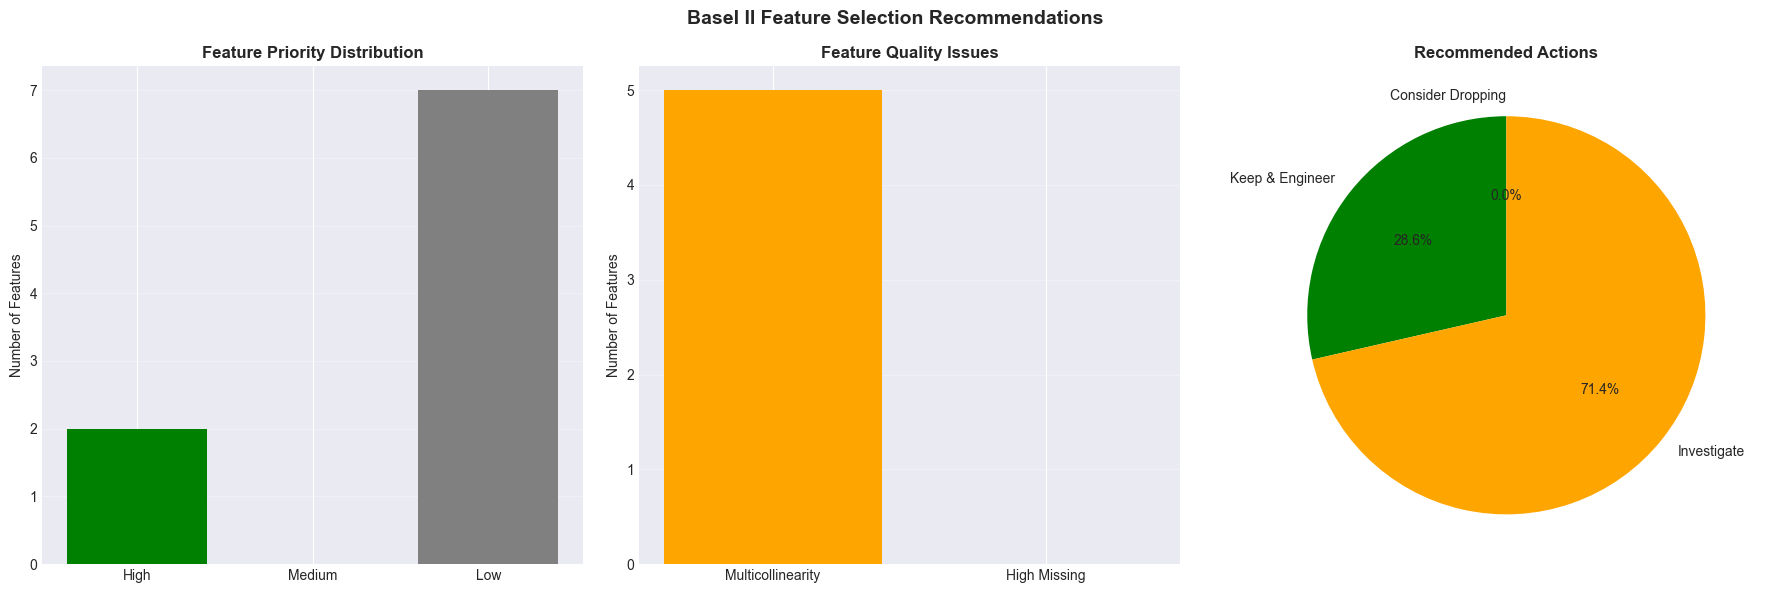

In [35]:
# %%
# Create summary visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Feature priority distribution
priority_counts = {
    'High': len(recommendations['high_priority_features']),
    'Medium': len(recommendations['medium_priority_features']),
    'Low': len(recommendations['low_priority_features'])
}
axes[0].bar(priority_counts.keys(), priority_counts.values(), 
           color=['green', 'orange', 'gray'])
axes[0].set_ylabel('Number of Features')
axes[0].set_title('Feature Priority Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Issues summary
issues = {
    'Multicollinearity': len(recommendations['multicollinearity_issues']),
    'High Missing': len(recommendations['features_to_drop'])
}
axes[1].bar(issues.keys(), issues.values(), color=['orange', 'red'])
axes[1].set_ylabel('Number of Features')
axes[1].set_title('Feature Quality Issues', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Action recommendations
actions = {
    'Keep & Engineer': priority_counts['High'] + priority_counts['Medium'],
    'Investigate': len(recommendations['multicollinearity_issues']),
    'Consider Dropping': len(recommendations['features_to_drop'])
}
wedges, texts, autotexts = axes[2].pie(actions.values(), labels=actions.keys(), 
                                       autopct='%1.1f%%', startangle=90,
                                       colors=['green', 'orange', 'red'])
axes[2].set_title('Recommended Actions', fontsize=12, fontweight='bold')

plt.suptitle('Basel II Feature Selection Recommendations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../reports/task2_eda/visualizations/correlations/feature_recommendations.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 10. Export Correlation Results

In [37]:
# %%
print("="*80)
print("EXPORTING CORRELATION ANALYSIS RESULTS")
print("="*80)

# Create results directory
import os
os.makedirs('../../reports/task2_eda/statistics/correlation_matrices', exist_ok=True)

# Export correlation matrices
for method_name, corr_matrix in correlation_methods.items():
    filename = f'../../reports/task2_eda/statistics/correlation_matrices/{method_name}_correlation.csv'
    corr_matrix.to_csv(filename)
    print(f"✅ Exported {method_name} correlation matrix: {filename}")

# Export feature recommendations
recommendations_df = pd.DataFrame({
    'feature': numerical_features,
    'pearson_with_fraud': df[numerical_features].corrwith(df['FraudResult']) if 'FraudResult' in df.columns else np.nan,
    'spearman_with_fraud': df[numerical_features].corrwith(df['FraudResult'], method='spearman') if 'FraudResult' in df.columns else np.nan,
    'missing_pct': (df[numerical_features].isnull().sum() / len(df)) * 100
})

# Add VIF if available
try:
    vif_results = calculate_vif(df)
    recommendations_df = recommendations_df.merge(
        vif_results[['feature', 'VIF', 'multicollinearity_risk']],
        on='feature',
        how='left'
    )
except:
    recommendations_df['VIF'] = np.nan
    recommendations_df['multicollinearity_risk'] = np.nan

# Save recommendations
recommendations_df.to_csv('../../reports/task2_eda/statistics/feature_recommendations.csv', index=False)
print(f"✅ Exported feature recommendations: ../../reports/task2_eda/statistics/feature_recommendations.csv")

EXPORTING CORRELATION ANALYSIS RESULTS
✅ Exported pearson correlation matrix: ../../reports/task2_eda/statistics/correlation_matrices/pearson_correlation.csv
✅ Exported spearman correlation matrix: ../../reports/task2_eda/statistics/correlation_matrices/spearman_correlation.csv
✅ Exported kendall correlation matrix: ../../reports/task2_eda/statistics/correlation_matrices/kendall_correlation.csv


✅ Exported feature recommendations: ../../reports/task2_eda/statistics/feature_recommendations.csv


In [43]:
# %%
# Generate summary report
summary_report = f"""
CORRELATION ANALYSIS SUMMARY REPORT
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Dataset: {len(df):,} transactions, {len(df.columns)} features
Basel II Compliance Check: {'PASS' if len(recommendations['multicollinearity_issues']) == 0 else 'FAIL'}

KEY FINDINGS:
1. Feature Relationships: {correlation_methods['pearson'].shape[0]} features analyzed
2. Multicollinearity Issues: {len(recommendations['multicollinearity_issues'])} features with VIF > {BASEL_THRESHOLDS['vif_threshold']}
3. Predictive Features: {len(recommendations['high_priority_features'])} features show strong correlation with target
4. Data Quality: {len(recommendations['features_to_drop'])} features with >30% missing values

RECOMMENDATIONS:
1. Feature Selection: Prioritize {len(recommendations['high_priority_features'])} high-correlation features
2. Multicollinearity: Address {len(recommendations['multicollinearity_issues'])} high-VIF features
3. Data Cleaning: Consider dropping {len(recommendations['features_to_drop'])} features with high missing values
4. Model Development: Use Spearman correlation for non-linear relationships

NEXT STEPS FOR TASK 3:
• Implement feature selection based on correlation analysis
• Handle multicollinearity through PCA or feature combination
• Create interaction features for weakly correlated variables
• Validate feature stability over time
"""

# Save summary report
with open('../../reports/task2_eda/recommendations/correlation_analysis_summary.md', 'w') as f:
    f.write(summary_report)

print(f"✅ Exported summary report: ../../reports/task2_eda/recommendations/correlation_analysis_summary.md")

print("\n" + "="*80)
print("✅ CORRELATION ANALYSIS COMPLETE!")
print("📊 Results exported to ../../reports/task2_eda/")
print("🚀 Proceed to Notebook 5: Missing Values Analysis")
print("="*80)

✅ Exported summary report: ../../reports/task2_eda/recommendations/correlation_analysis_summary.md

✅ CORRELATION ANALYSIS COMPLETE!
📊 Results exported to ../../reports/task2_eda/
🚀 Proceed to Notebook 5: Missing Values Analysis
